# Input Preparation

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import librosa
import librosa.display


df=pd.read_csv('TinySOL\TinySOL_metadata (1).csv')
num_rows=df.shape[0]
num_samples=65025

mel_list=[]
for i in range(num_rows):
    signal,sr=librosa.load('TinySOL/'+df['Path'][i],sr=44100)
    if signal.shape[0]>num_samples:
        signal=signal[:num_samples]
    elif signal.shape[0]<num_samples:
        signal=np.pad(signal,(0,num_samples-signal.shape[0]),'constant')
    mel = librosa.feature.melspectrogram(y=signal, sr=sr, n_fft=2048, hop_length=512, n_mels=32)
    mel_dB = librosa.power_to_db(mel)
    mel_list.append(mel_dB)
X=np.array(mel_list)
X = X.reshape(X.shape[0], X.shape[1], X.shape[2], 1)
X.shape



(2913, 32, 128, 1)

In [2]:
from sklearn.preprocessing import LabelEncoder

target_values = df['Instrument (in full)']
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(target_values)
num_classes=len(np.unique(y))
num_classes

14

# Preprocessing

In [30]:
from sklearn.model_selection import train_test_split
import IPython.display as ipd

X_norm=X/np.max(np.abs(X))

X_train1, X_test, y_train1, y_test = train_test_split(X_norm, y, test_size=0.25,random_state=0)


# CNN Model

In [4]:
from tensorflow.keras import models,layers,callbacks
import tensorflow as tf

def CNN(X_train,y_train,X_val,y_val,epochs):
    model = models.Sequential(
    [
        layers.Conv2D(16, (3, 3), padding='same',strides=(1,1), input_shape=(32,128,1)),
        layers.BatchNormalization(),
        layers.ReLU(),

        layers.MaxPooling2D((2, 2),strides=(2,2)),

        layers.Conv2D(32, (3, 3),strides=(1,1) ,padding='same'),
        layers.BatchNormalization(),
        layers.ReLU(),

        layers.MaxPooling2D((2, 2),strides=(2,2)),

        layers.Flatten(),
        
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.3),
        layers.BatchNormalization(),

        layers.Dense(num_classes,activation='softmax'),
    ])
    model.compile(optimizer='adam',loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])
    
    reduce_lr = callbacks.ReduceLROnPlateau(
        monitor='val_accuracy', 
        factor=0.1, 
        patience=5, 
        verbose=1, 
        mode='auto', 
        min_delta=0.001, 
        cooldown=0, 
        min_lr=0
    )
    
    history=model.fit(X_train,y_train,validation_data=(X_val,y_val),callbacks=[reduce_lr],epochs=epochs)
    return model,history



In [5]:
def plot(history,target_type):
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    plt.suptitle('Plots for ' + target_type)
    plt.show()

In [33]:
model1,history1=CNN(X_train1,y_train1,X_test,y_test,30)

Epoch 1/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.2423 - loss: 2.3203 - val_accuracy: 0.0905 - val_loss: 2.5828 - learning_rate: 0.0010
Epoch 2/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.6562 - loss: 1.2696 - val_accuracy: 0.0905 - val_loss: 2.7312 - learning_rate: 0.0010
Epoch 3/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.7206 - loss: 0.9933 - val_accuracy: 0.0947 - val_loss: 2.8434 - learning_rate: 0.0010
Epoch 4/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.8036 - loss: 0.7909 - val_accuracy: 0.1399 - val_loss: 2.5268 - learning_rate: 0.0010
Epoch 5/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.8322 - loss: 0.6314 - val_accuracy: 0.3292 - val_loss: 1.8687 - learning_rate: 0.0010
Epoch 6/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.8774 - loss: 0.5194 - val_accuracy: 0.6063 - val_loss: 1.3246 - learning_rate: 0.0010
Epoch 7/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.8916 - loss: 0.4578 - val_acc

In [34]:
model1.evaluate(X_test,y_test)

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9708 - loss: 0.0789


[0.06925947964191437, 0.9794238805770874]

In [35]:
pred_array= model1.predict(X_norm)

92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


# Dataset Class

In [36]:
import os
class general_dataset:

    def __init__(self,index):
        self.index=index

    def filename(self):
        path = df['Path'].iloc[self.index]
        filename = os.path.basename(path)
        return filename 
    
    def audio_file(self):
        auido_file,_=librosa.load('TinySOL/'+df['Path'][self.index],sr=44100)
        return auido_file.reshape(1,auido_file.shape[0])
    
    def mel(self):
        mel = librosa.feature.melspectrogram(y=self.audio_file(), sr=44100, n_fft=2048, hop_length=512, n_mels=32)
        mel_dB = librosa.power_to_db(mel)
        return mel_dB
    
    def Dict(self):
        ground_truth= label_encoder.inverse_transform([y[self.index]])
        pseudo_label= label_encoder.inverse_transform([np.argmax(pred_array[self.index])])
        Dict={'file':self.filename(),'audio':self.audio_file(),'mel':self.mel(),'gt':ground_truth,'pseudo':pseudo_label}
        return Dict


In [37]:
y_pred = np.array([label_encoder.transform(general_dataset(i).Dict()['pseudo']) for i in range(num_rows)]).flatten()
X_train2, X_val2, y_train2, y_val2 = train_test_split(X_norm, y_pred, test_size=0.25,random_state=0)


In [38]:
model2,history2=CNN(X_train2,y_train2,X_test,y_test,30)

c:\Users\ASUS\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - accuracy: 0.3112 - loss: 2.2319 - val_accuracy: 0.0905 - val_loss: 2.6718 - learning_rate: 0.0010
Epoch 2/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.6428 - loss: 1.2435 - val_accuracy: 0.0905 - val_loss: 3.2620 - learning_rate: 0.0010
Epoch 3/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.7448 - loss: 0.9915 - val_accuracy: 0.1125 - val_loss: 2.9328 - learning_rate: 0.0010
Epoch 4/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.8008 - loss: 0.8060 - val_accuracy: 0.0905 - val_loss: 3.5476 - learning_rate: 0.0010
Epoch 5/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.8176 - loss: 0.7088 - val_accuracy: 0.1934 - val_loss: 2.7315 - learning_rate: 0.0010
Epoch 6/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.8619 - loss: 0.5707 - val_accuracy: 0.4554 - val_loss: 1.5071 - learning_rate: 0.0010
Epoch 7/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.8696 - loss: 0.5413 - val_acc

In [39]:
model2.evaluate(X_test,y_test)

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9713 - loss: 0.0860


[0.08953551948070526, 0.9711934328079224]

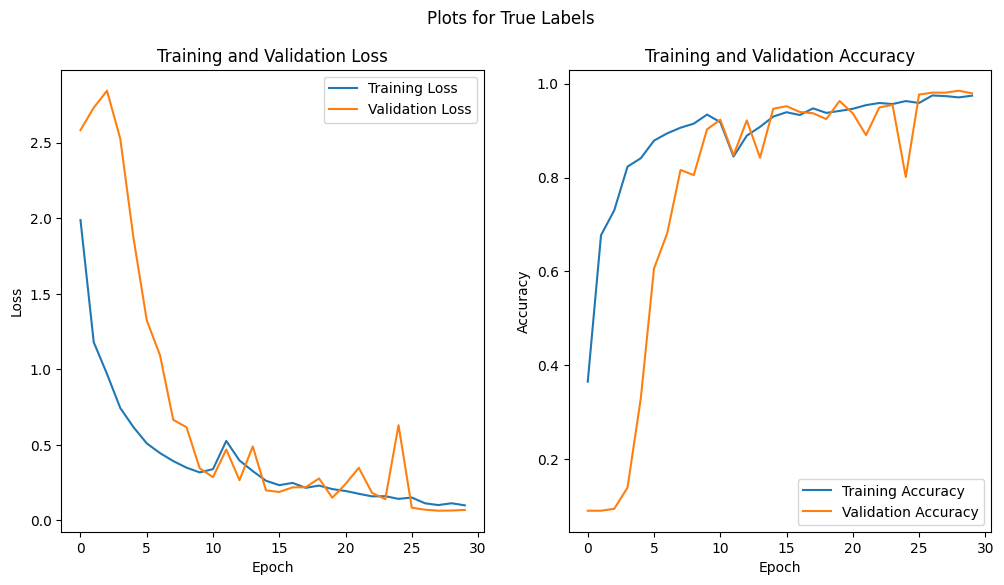

In [40]:
plot(history=history1,target_type='True Labels')

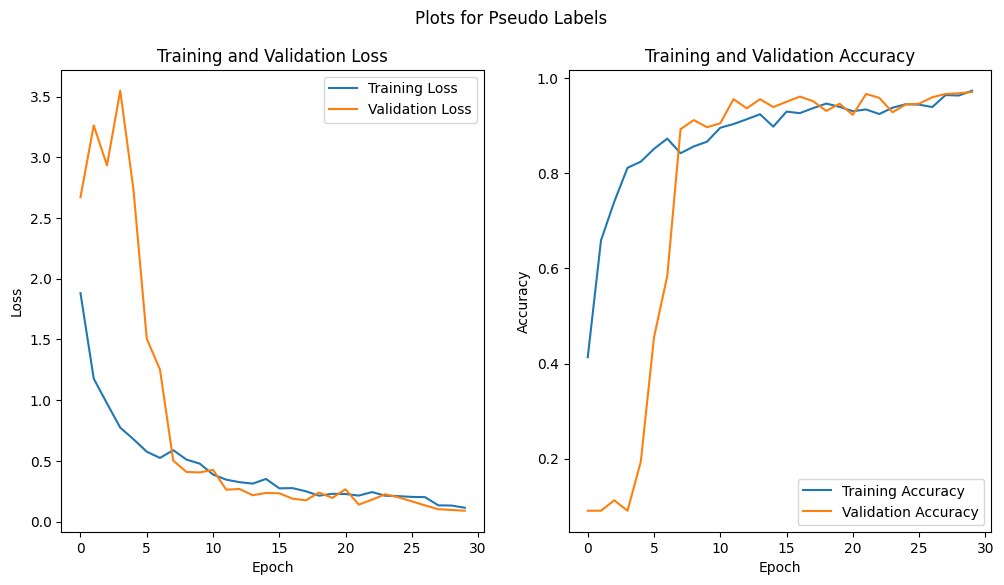

In [41]:
plot(history=history2,target_type='Pseudo Labels')